# Final Project PMA: Forecasting Total Pengunjung dengan Metode GRU

```
Disusun Oleh
Nadila Nur Sholekah (5026211041)
Fathia Rahmanisa D (5026211067)
PMA (C)

```

#Import Library

In [ ]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense,Dropout,SimpleRNN,LSTM,GRU
from keras.models import Sequential
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.svm import SVR
from tabulate import tabulate

#Import Dataset

In [ ]:
jkt = pd.read_csv('https://raw.githubusercontent.com/NadilaNurSholekah/kel17pmac/main/Jakarta%202015%20-%202022.csv')
jkt

,datetime,total_visitor,total_accomodation
0,1/1/2014,193017,16332
1,2/1/2014,185851,17101
2,3/1/2014,204004,17438
3,4/1/2014,186373,17943
4,5/1/2014,190716,18123
...,...,...,...
103,8/1/2022,121438,68569
104,9/1/2022,111139,69382
105,10/1/2022,112588,69626
106,11/1/2022,113958,69843


#Preprocessing

## Cek Missing Value

In [ ]:
#cek nilai null
jkt.isna().sum()

datetime              0
total_visitor         0
total_accomodation    0
dtype: int64

Setelah ini, kita akan menentukan panjang data sehingga kita dapat membagi data untuk beberapa sekanario pemodelan di metode GRU

In [ ]:
len(jkt)

108

Diketahui bahwa panjang data keseluruhan adalah 108 baris data. Dalam pengerjaan tugas ini terdapat 3 skenario pembagian data training dan testing, yaitu sebagai berikut:

- Skenario 1: 80% training (86) dan 20% testing (22)
- Skenario 2: 70% training (76) dan 30% testng (32)
- Skenario 3: 60% training (65) dan 40% testing (43)


In [ ]:
datetime = pd.to_datetime(jkt['datetime'])
print(datetime)

0     2014-01-01
1     2014-02-01
2     2014-03-01
3     2014-04-01
4     2014-05-01
         ...    
103   2022-08-01
104   2022-09-01
105   2022-10-01
106   2022-11-01
107   2022-12-01
Name: datetime, Length: 108, dtype: datetime64[ns]


In [ ]:
input_col = list(jkt)[1:3]
print(input_col)

['total_visitor', 'total_accomodation']


In [ ]:
data_for_pred = jkt[input_col].astype(float)

In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(data_for_pred)
scaled_data_pred = scaler.transform(data_for_pred)

#GRU

##Skenario 1

80% training (86) dan 20% testing (22)

###Spliting Data

In [ ]:
# Define sequence length and features
n_past = 12  # Number of time steps in each sequence
num_features = len(data_for_pred.columns)
n_future = 1

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range (n_past, len(scaled_data_pred) - n_future +1):
    seq = scaled_data_pred[i - n_past:i, 0:scaled_data_pred.shape[1]]
    label = scaled_data_pred[i + n_future - 1:i + n_future, 0]  # 'total_visitor' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
train_x, test_x = sequences[:train_size], sequences[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)
print("Test X shape:", test_x.shape)
print("Test Y shape:", test_y.shape)

Train X shape: (76, 12, 2)
Train Y shape: (76, 1)
Test X shape: (20, 12, 2)
Test Y shape: (20, 1)


###Model

In [ ]:
# Define the GRU model
model = Sequential()

# Add GRU layers with dropout
model.add(GRU(units=256, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(units=128, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(units=64, return_sequences=False))

# Add a dense output layer
model.add(Dense(units=1))

model.summary()

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 12, 256)           199680    
                                                                 
 dropout_2 (Dropout)         (None, 12, 256)           0         
                                                                 
 gru_4 (GRU)                 (None, 12, 128)           148224    
                                                                 
 dropout_3 (Dropout)         (None, 12, 128)           0         
                                                                 
 gru_5 (GRU)                 (None, 64)                37248     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 385217 (1.47 MB)
Trainable params: 38521

In [ ]:
# Train the model
history = model.fit(
    train_x, train_y,
    epochs=100,
    batch_size=64,
    validation_split=0.2,  # Use part of the training data as validation
)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.4802 - val_loss: 0.0387
Epoch 2/100
1/1 [==============================] - 0s 86ms/step - loss: 0.1439 - val_loss: 0.1812
Epoch 3/100
1/1 [==============================] - 0s 77ms/step - loss: 0.0176 - val_loss: 0.4345
Epoch 4/100
1/1 [==============================] - 0s 68ms/step - loss: 0.0889 - val_loss: 0.4388
Epoch 5/100
1/1 [==============================] - 0s 76ms/step - loss: 0.1017 - val_loss: 0.3096
Epoch 6/100
1/1 [==============================] - 0s 71ms/step - loss: 0.0464 - val_loss: 0.1899
Epoch 7/100
1/1 [==============================] - 0s 72ms/step - loss: 0.0157 - val_loss: 0.1157
Epoch 8/100
1/1 [==============================] - 0s 72ms/step - loss: 0.0218 - val_loss: 0.0781
Epoch 9/100
1/1 [==============================] - 0s 71ms/step - loss: 0.0419 - val_loss: 0.0633
Epoch 10/100
1/1 [==============================] - 0s 70ms/step - loss: 0.0514 - val_loss: 0.0617
Epoch 11/100
1/1 [===

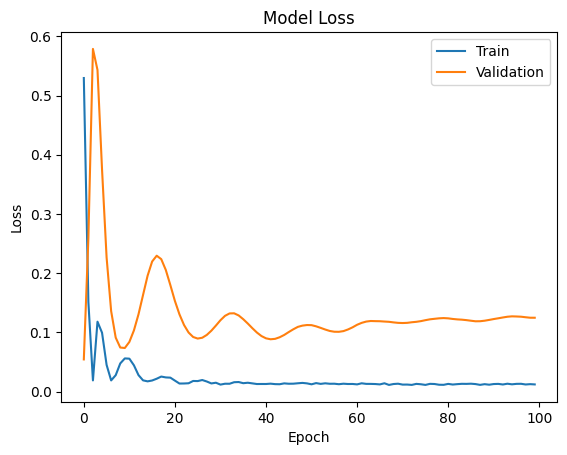

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Retrieve loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a table with loss values
loss_table = []
for epoch in range(len(train_loss)):
    loss_table.append([epoch+1, train_loss[epoch], val_loss[epoch]])

headers = ["Epoch", "Train Loss", "Validation Loss"]

# Print the loss table using tabulate
print(tabulate(loss_table, headers=headers, tablefmt='fancy_grid'))

╒═════════╤══════════════╤═══════════════════╕
│   Epoch │   Train Loss │   Validation Loss │
╞═════════╪══════════════╪═══════════════════╡
│       1 │    0.529594  │         0.0542229 │
├─────────┼──────────────┼───────────────────┤
│       2 │    0.15121   │         0.259451  │
├─────────┼──────────────┼───────────────────┤
│       3 │    0.01877   │         0.578752  │
├─────────┼──────────────┼───────────────────┤
│       4 │    0.11795   │         0.543232  │
├─────────┼──────────────┼───────────────────┤
│       5 │    0.0992948 │         0.374988  │
├─────────┼──────────────┼───────────────────┤
│       6 │    0.0449802 │         0.226441  │
├─────────┼──────────────┼───────────────────┤
│       7 │    0.0187563 │         0.135794  │
├─────────┼──────────────┼───────────────────┤
│       8 │    0.0275967 │         0.091041  │
├─────────┼──────────────┼───────────────────┤
│       9 │    0.0474554 │         0.0743181 │
├─────────┼──────────────┼───────────────────┤
│      10 │  

###Forecast Data Train

3/3 [==============================] - 2s 22ms/step


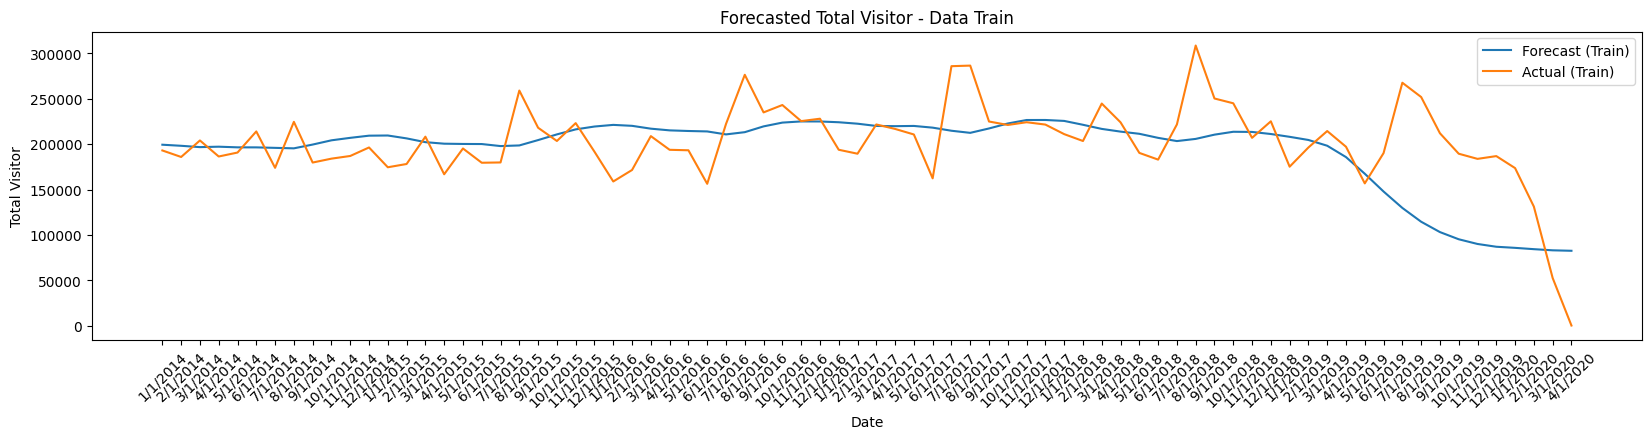

Data Forecast - Data Train
         Date  Forecast_Train  Actual_Train
0    1/1/2014   199335.343750        193017
1    2/1/2014   198150.031250        185851
2    3/1/2014   196687.109375        204004
3    4/1/2014   197158.484375        186373
4    5/1/2014   196445.734375        190716
..        ...             ...           ...
71  12/1/2019    87090.304688        186810
72   1/1/2020    85874.726562        173614
73   2/1/2020    84430.742188        131237
74   3/1/2020    83165.406250         52721
75   4/1/2020    82653.523438           424

[76 rows x 3 columns]


In [ ]:
# Forecast Data Train
# Prediksi pada data train
train_predictions = model.predict(train_x)

# Invers transformasi prediksi ke skala aslinya
train_predictions_inverse = scaler.inverse_transform(np.repeat(train_predictions, data_for_pred.shape[1], axis=-1))[:, 0]

# Plot hasil prediksi bersama dengan data asli untuk data train
plt.figure(figsize=(20, 4))
plt.plot(jkt['datetime'][:len(train_predictions_inverse)], train_predictions_inverse, label='Forecast (Train)')
plt.plot(jkt['datetime'][:len(train_predictions_inverse)], jkt['total_visitor'][:len(train_predictions_inverse)], label='Actual (Train)')
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.title('Forecasted Total Visitor - Data Train')
plt.legend()

# Penyesuaian rotasi pada sumbu x
plt.xticks(rotation=45)  # Memutar teks pada sumbu x sebesar 45 derajat

plt.show()
# Membuat DataFrame untuk data forecast dari data train
df_forecast_train = pd.DataFrame({
    'Date': jkt['datetime'][:len(train_predictions_inverse)],
    'Forecast_Train': train_predictions_inverse,
    'Actual_Train': jkt['total_visitor'][:len(train_predictions_inverse)]
})

# Menampilkan tabel untuk data forecast dari data train
print("Data Forecast - Data Train")
print(df_forecast_train)

###Forecast Data Test

1/1 [==============================] - 0s 55ms/step

Data Forecast - Data Test
          Date  Forecast_Test  Actual_Test
88    5/1/2021   83031.289062        12782
89    6/1/2021   83525.476562        13483
90    7/1/2021   83990.015625         5471
91    8/1/2021   83887.531250         1071
92    9/1/2021   83093.093750         4135
93   10/1/2021   82143.367188        13731
94   11/1/2021   81892.031250        19046
95   12/1/2021   82509.929688        16749
96    1/1/2022   83431.320312        14089
97    2/1/2022   84295.328125        15406
98    3/1/2022   84939.351562        23320
99    4/1/2022   85907.609375        36061
100   5/1/2022   87895.882812        57844
101   6/1/2022   91796.578125        85587
102   7/1/2022   98194.703125       119197
103   8/1/2022  107618.070312       121438
104   9/1/2022  117875.617188       111139
105  10/1/2022  126611.593750       112588
106  11/1/2022  133378.203125       113958
107  12/1/2022  138444.296875       124555


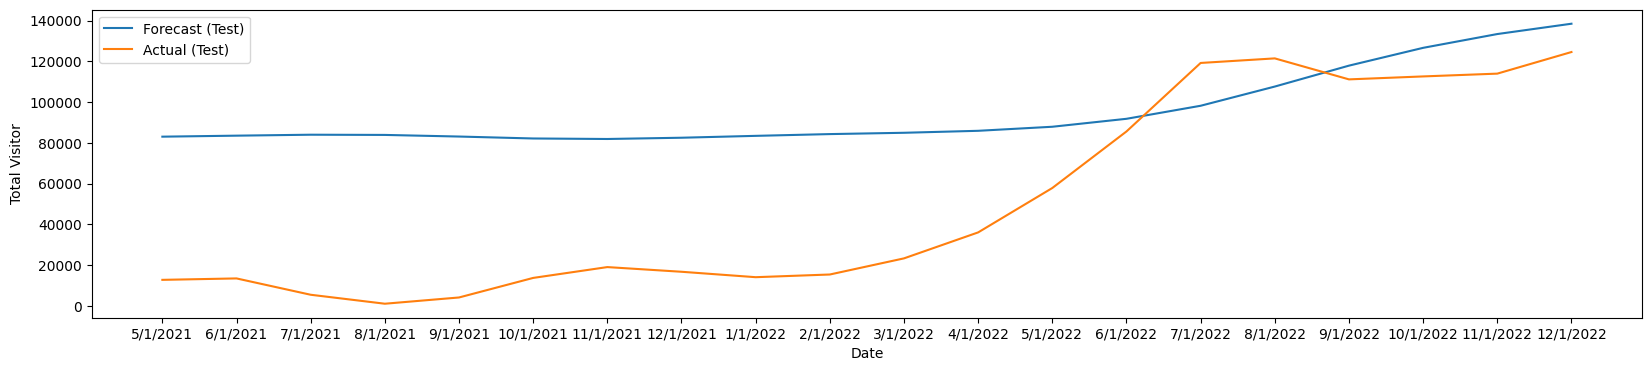

In [ ]:
# Forecast Data Test
# Prediksi pada data test
test_predictions = model.predict(test_x)

# Invers transformasi prediksi ke skala aslinya
test_predictions_inverse = scaler.inverse_transform(np.repeat(test_predictions, data_for_pred.shape[1], axis=-1))[:, 0]

# Plot hasil prediksi bersama dengan data asli untuk data test
plt.figure(figsize=(20, 4))
plt.plot(jkt['datetime'][-len(test_predictions_inverse):], test_predictions_inverse, label='Forecast (Test)')
plt.plot(jkt['datetime'][-len(test_predictions_inverse):], jkt['total_visitor'][-len(test_predictions_inverse):], label='Actual (Test)')
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.legend()
plt

# Membuat DataFrame untuk data forecast dari data test
df_forecast_test = pd.DataFrame({
    'Date': jkt['datetime'][-len(test_predictions_inverse):],
    'Forecast_Test': test_predictions_inverse,
    'Actual_Test': jkt['total_visitor'][-len(test_predictions_inverse):]
})

# Menampilkan tabel untuk data forecast dari data test
print("\nData Forecast - Data Test")
print(df_forecast_test)

###Visual Forecast Train dan Test

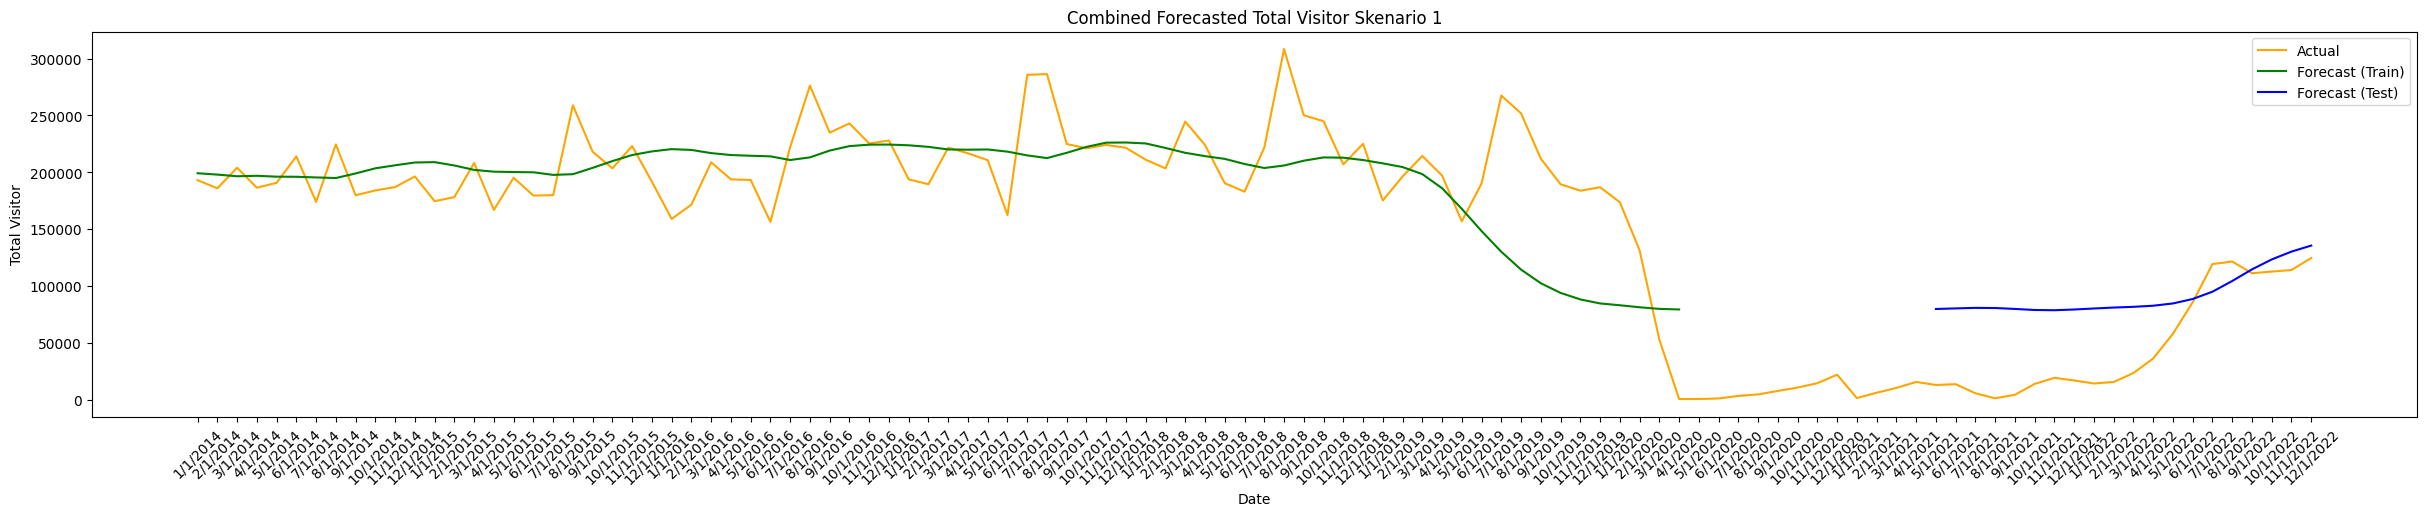

In [ ]:
plt.figure(figsize=(30, 5))

# Plot data aktual
plt.plot(jkt['datetime'], jkt['total_visitor'], label='Actual', color='orange')

# Plot hasil prediksi train
plt.plot(jkt['datetime'][:len(train_predictions_inverse)], train_predictions_inverse, label='Forecast (Train)', color='green')

# Plot hasil prediksi test
plt.plot(jkt['datetime'][-len(test_predictions_inverse):], test_predictions_inverse, label='Forecast (Test)', color='blue')

plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.title('Combined Forecasted Total Visitor Skenario 1')
plt.legend()
# Penyesuaian rotasi pada sumbu x
plt.xticks(rotation=45)  # Memutar teks pada sumbu x sebesar 45 derajat
plt.show()


###Predict for 12 month afterwards

In [ ]:
# Predict for 12 month afterwards
n_past = 1
n_month_for_prediction = 12
predict_period_month = pd.date_range(list(datetime)[-n_past], periods=n_month_for_prediction, freq='M').tolist()
print(predict_period_month)

[Timestamp('2022-12-31 00:00:00', freq='M'), Timestamp('2023-01-31 00:00:00', freq='M'), Timestamp('2023-02-28 00:00:00', freq='M'), Timestamp('2023-03-31 00:00:00', freq='M'), Timestamp('2023-04-30 00:00:00', freq='M'), Timestamp('2023-05-31 00:00:00', freq='M'), Timestamp('2023-06-30 00:00:00', freq='M'), Timestamp('2023-07-31 00:00:00', freq='M'), Timestamp('2023-08-31 00:00:00', freq='M'), Timestamp('2023-09-30 00:00:00', freq='M'), Timestamp('2023-10-31 00:00:00', freq='M'), Timestamp('2023-11-30 00:00:00', freq='M')]


In [ ]:
# Predict total_visitor using the trained model
predictions = model.predict(test_x[-n_month_for_prediction:])

# Calculate evaluation metrics
mae1 = mean_absolute_error(test_y[-n_month_for_prediction:], predictions)
mse1 = mean_squared_error(test_y[-n_month_for_prediction:], predictions)
mape1 = mean_absolute_percentage_error(test_y[-n_month_for_prediction:], predictions)

print("Mean Absolute Error (MAE):", mae1)
print("Mean Squared Error (MSE):", mse1)
print("Mean Absolute Percentage Error (MAPE):", mape1)

1/1 [==============================] - 1s 885ms/step
Mean Absolute Error (MAE): 0.08252741876462026
Mean Squared Error (MSE): 0.011150424798235607
Mean Absolute Percentage Error (MAPE): 1.0253918550020054


In [ ]:
prediction_copy = np.repeat(predictions, data_for_pred.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copy)[:,0]

<ipython-input-34-fafcf01f28e4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['datetime'] = pd.to_datetime(actual['datetime'])


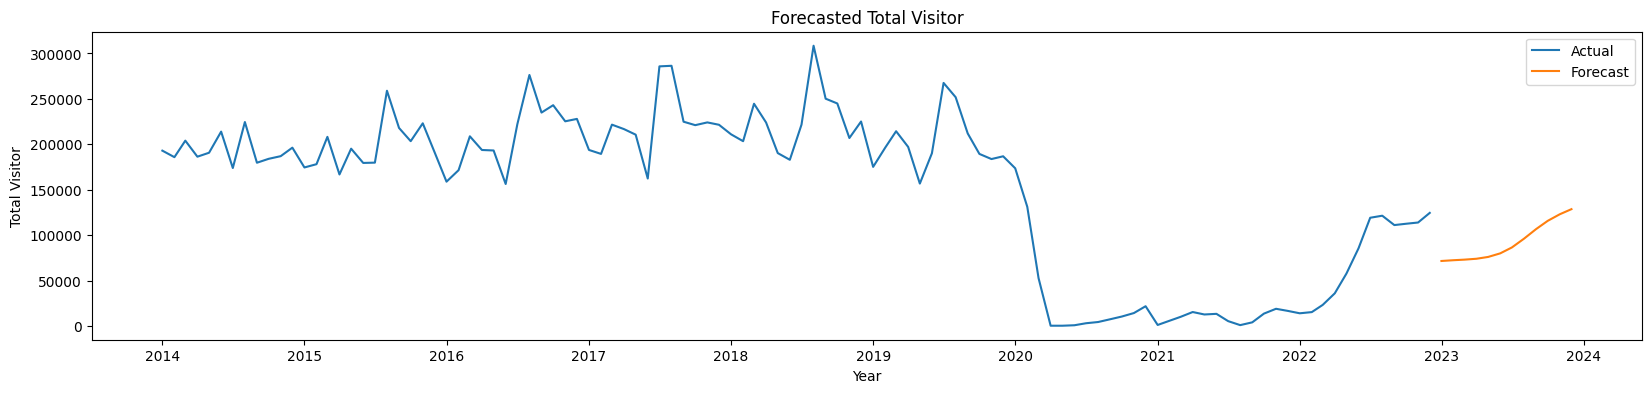

╒═════════════════════╤══════════════╕
│ Datetime            │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │      71641.6 │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │      72478.8 │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │      73109.4 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │      74087.3 │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │      76085.4 │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │      80019.4 │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │      86517.6 │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │      96126.4 │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │     106666   │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │     115774   │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │     123023   │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

In [ ]:
forecast_dates = []

for time_i in predict_period_month:
    forecast_dates.append(time_i.date())

df_forecast_1 = pd.DataFrame({'Date': forecast_dates, 'Total Visitor' : y_pred_future})
df_forecast_1['Date'] = pd.to_datetime(df_forecast_1['Date'])

plt.figure(figsize=(20,4))
# Assuming 'actual' contains the actuals data with 'Datetime' and 'total_visitor' columns
actual = jkt[['datetime', 'total_visitor']]
actual['datetime'] = pd.to_datetime(actual['datetime'])
actual = actual.loc[actual['datetime'] >= '2014-01-01']

sns.lineplot(data=actual, x='datetime', y='total_visitor', label='Actual')
sns.lineplot(data=df_forecast_1, x='Date', y='Total Visitor', label='Forecast')

plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.title('Forecasted Total Visitor')
plt.legend()
plt.show()

# Generate the forecast dates from January 2023 to December 2023
forecast_dates_1 = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

# Create a list of forecast dates and prediction values
data = list(zip(forecast_dates_1, y_pred_future))

# Create a list of headers for the table
headers = ['Datetime', 'Prediction']
table_pred = tabulate(data, headers=headers, tablefmt='fancy_grid')
# Print the table
print(table_pred)

##Skenario 2

70% training (76) dan 30% testng (32)


###Splitting Data

In [ ]:
# Define sequence length and features
n_past = 12  # Number of time steps in each sequence
num_features = len(data_for_pred.columns)
n_future = 1

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range (n_past, len(scaled_data_pred) - n_future +1):
    seq = scaled_data_pred[i - n_past:i, 0:scaled_data_pred.shape[1]]
    label = scaled_data_pred[i + n_future - 1:i + n_future, 0]  # 'total_visitor' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.7 * len(sequences))
train_x2, test_x2 = sequences[:train_size], sequences[train_size:]
train_y2, test_y2 = labels[:train_size], labels[train_size:]

print("Train X 2 shape:", train_x2.shape)
print("Train Y 2 shape:", train_y2.shape)
print("Test X 2 shape:", test_x2.shape)
print("Test Y 2 shape:", test_y2.shape)

Train X 2 shape: (67, 12, 2)
Train Y 2 shape: (67, 1)
Test X 2 shape: (29, 12, 2)
Test Y 2 shape: (29, 1)


###Model

In [ ]:
# Define the GRU model
model2 = Sequential()

# Add GRU layers with dropout
model2.add(GRU(units=256, input_shape=(train_x2.shape[1], train_x2.shape[2]), return_sequences=True))
model2.add(Dropout(0.2))

model2.add(GRU(units=128, return_sequences=True))
model2.add(Dropout(0.2))

model2.add(GRU(units=64, return_sequences=False))

# Add a dense output layer
model2.add(Dense(units=1))

model2.summary()

# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 12, 256)           199680    
                                                                 
 dropout_4 (Dropout)         (None, 12, 256)           0         
                                                                 
 gru_7 (GRU)                 (None, 12, 128)           148224    
                                                                 
 dropout_5 (Dropout)         (None, 12, 128)           0         
                                                                 
 gru_8 (GRU)                 (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 385217 (1.47 MB)
Trainable params: 38521

In [ ]:
# Train the model
history2 = model2.fit(
    train_x2, train_y2,
    epochs=100,
    batch_size=64,
    validation_split=0.2,  # Use part of the training data as validation
)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.5761 - val_loss: 0.1195
Epoch 2/100
1/1 [==============================] - 0s 69ms/step - loss: 0.2115 - val_loss: 0.0945
Epoch 3/100
1/1 [==============================] - 0s 67ms/step - loss: 0.0331 - val_loss: 0.2935
Epoch 4/100
1/1 [==============================] - 0s 70ms/step - loss: 0.0498 - val_loss: 0.4259
Epoch 5/100
1/1 [==============================] - 0s 73ms/step - loss: 0.1099 - val_loss: 0.3363
Epoch 6/100
1/1 [==============================] - 0s 69ms/step - loss: 0.0704 - val_loss: 0.2082
Epoch 7/100
1/1 [==============================] - 0s 73ms/step - loss: 0.0265 - val_loss: 0.1248
Epoch 8/100
1/1 [==============================] - 0s 68ms/step - loss: 0.0150 - val_loss: 0.0874
Epoch 9/100
1/1 [==============================] - 0s 78ms/step - loss: 0.0291 - val_loss: 0.0750
Epoch 10/100
1/1 [==============================] - 0s 70ms/step - loss: 0.0453 - val_loss: 0.0719
Epoch 11/100
1/1 [===

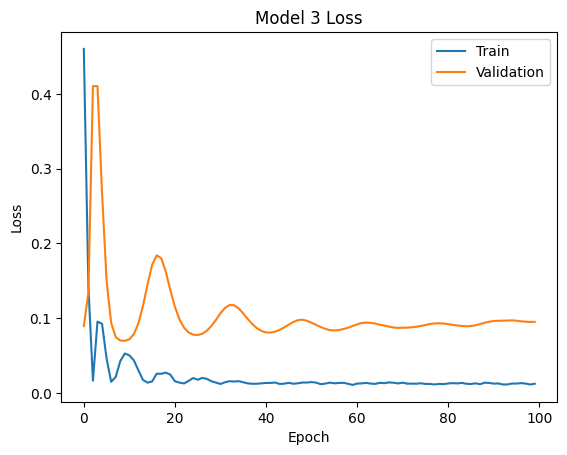

In [57]:
# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model 3 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Retrieve loss values
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Create a table with loss values
loss_table = []
for epoch in range(len(train_loss)):
    loss_table.append([epoch+1, train_loss[epoch], val_loss[epoch]])

headers = ["Epoch", "Train Loss", "Validation Loss"]

# Print the loss table using tabulate
print(tabulate(loss_table, headers=headers, tablefmt='fancy_grid'))

╒═════════╤══════════════╤═══════════════════╕
│   Epoch │   Train Loss │   Validation Loss │
╞═════════╪══════════════╪═══════════════════╡
│       1 │    0.576098  │         0.119513  │
├─────────┼──────────────┼───────────────────┤
│       2 │    0.21148   │         0.0944605 │
├─────────┼──────────────┼───────────────────┤
│       3 │    0.0331092 │         0.293489  │
├─────────┼──────────────┼───────────────────┤
│       4 │    0.0497908 │         0.425858  │
├─────────┼──────────────┼───────────────────┤
│       5 │    0.109942  │         0.33625   │
├─────────┼──────────────┼───────────────────┤
│       6 │    0.0704308 │         0.208213  │
├─────────┼──────────────┼───────────────────┤
│       7 │    0.0265435 │         0.124831  │
├─────────┼──────────────┼───────────────────┤
│       8 │    0.0149987 │         0.0874115 │
├─────────┼──────────────┼───────────────────┤
│       9 │    0.0291287 │         0.0749999 │
├─────────┼──────────────┼───────────────────┤
│      10 │  

###Forecast Data Train

3/3 [==============================] - 0s 11ms/step


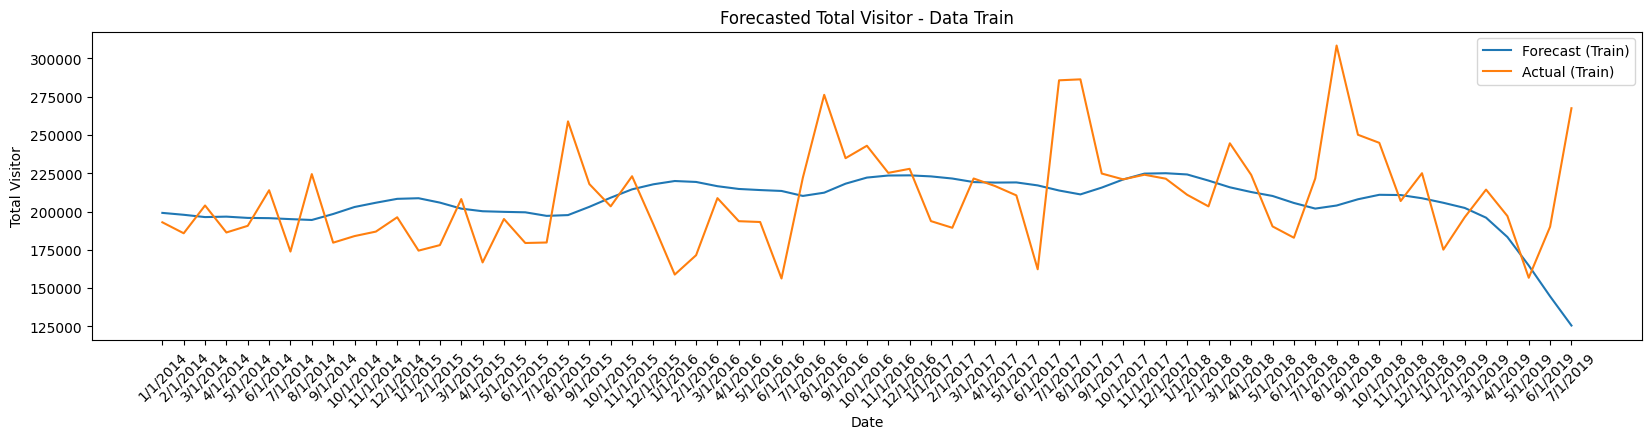

Data Forecast - Data Train
        Date  Forecast_Train  Actual_Train
0   1/1/2014   199161.531250        193017
1   2/1/2014   197923.921875        185851
2   3/1/2014   196423.312500        204004
3   4/1/2014   196717.343750        186373
4   5/1/2014   195884.593750        190716
..       ...             ...           ...
62  3/1/2019   196044.000000        214366
63  4/1/2019   183406.640625        197112
64  5/1/2019   164794.953125        156796
65  6/1/2019   144658.609375        190120
66  7/1/2019   125608.585938        267508

[67 rows x 3 columns]


In [ ]:
# Forecast Data Train
# Prediksi pada data train
train_predictions2 = model.predict(train_x2)

# Invers transformasi prediksi ke skala aslinya
train_predictions_inverse2 = scaler.inverse_transform(np.repeat(train_predictions2, data_for_pred.shape[1], axis=-1))[:, 0]

# Plot hasil prediksi bersama dengan data asli untuk data train
plt.figure(figsize=(20, 4))
plt.plot(jkt['datetime'][:len(train_predictions_inverse2)], train_predictions_inverse2, label='Forecast (Train)')
plt.plot(jkt['datetime'][:len(train_predictions_inverse2)], jkt['total_visitor'][:len(train_predictions_inverse2)], label='Actual (Train)')
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.title('Forecasted Total Visitor - Data Train')
plt.legend()

# Penyesuaian rotasi pada sumbu x
plt.xticks(rotation=45)  # Memutar teks pada sumbu x sebesar 45 derajat

plt.show()
# Membuat DataFrame untuk data forecast dari data train
df_forecast_train2 = pd.DataFrame({
    'Date': jkt['datetime'][:len(train_predictions_inverse2)],
    'Forecast_Train': train_predictions_inverse2,
    'Actual_Train': jkt['total_visitor'][:len(train_predictions_inverse2)]
})

# Menampilkan tabel untuk data forecast dari data train
print("Data Forecast - Data Train")
print(df_forecast_train2)

###Forecast Data Test

1/1 [==============================] - 0s 21ms/step

Data Forecast - Data Test
          Date  Forecast_Test  Actual_Test
79    8/1/2020  109092.109375         4487
80    9/1/2020   96322.476562         7528
81   10/1/2020   87193.835938        10529
82   11/1/2020   80986.843750        14365
83   12/1/2020   77072.109375        21858
84    1/1/2021   75168.031250         1248
85    2/1/2021   73216.250000         5966
86    3/1/2021   71662.757812        10198
87    4/1/2021   71089.242188        15482
88    5/1/2021   71480.750000        12782
89    6/1/2021   71958.812500        13483
90    7/1/2021   72415.328125         5471
91    8/1/2021   72272.046875         1071
92    9/1/2021   71435.648438         4135
93   10/1/2021   70456.843750        13731
94   11/1/2021   70188.523438        19046
95   12/1/2021   70783.093750        16749
96    1/1/2022   71641.570312        14089
97    2/1/2022   72478.781250        15406
98    3/1/2022   73109.398438        23320
99    4/1/2022   7

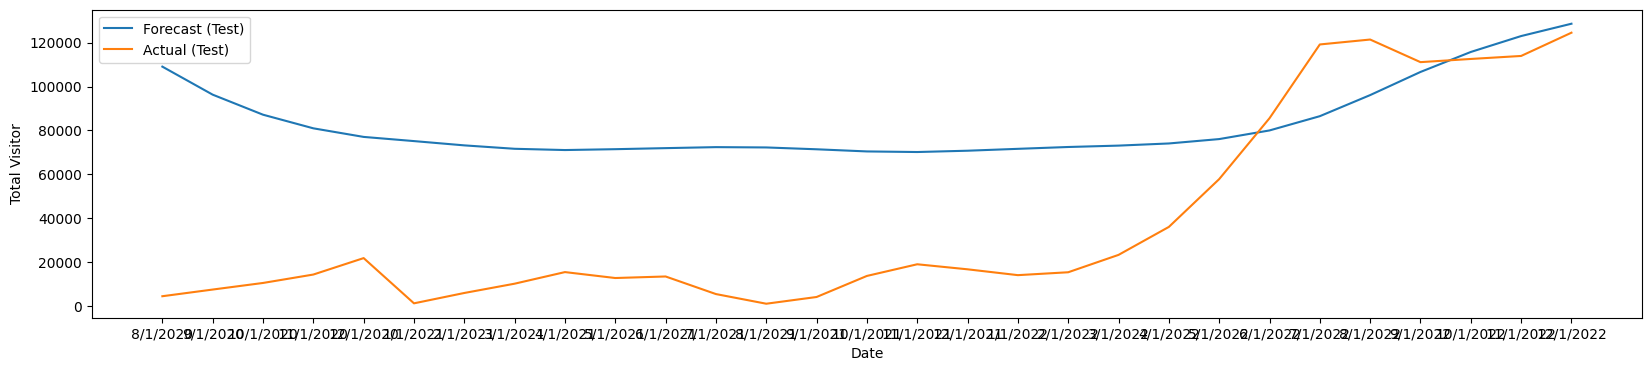

In [ ]:
# Forecast Data Test
# Prediksi pada data test
test_predictions2 = model.predict(test_x2)

# Invers transformasi prediksi ke skala aslinya
test_predictions_inverse2 = scaler.inverse_transform(np.repeat(test_predictions2, data_for_pred.shape[1], axis=-1))[:, 0]

# Plot hasil prediksi bersama dengan data asli untuk data test
plt.figure(figsize=(20, 4))
plt.plot(jkt['datetime'][-len(test_predictions_inverse2):], test_predictions_inverse2, label='Forecast (Test)')
plt.plot(jkt['datetime'][-len(test_predictions_inverse2):], jkt['total_visitor'][-len(test_predictions_inverse2):], label='Actual (Test)')
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.legend()
plt

# Membuat DataFrame untuk data forecast dari data test
df_forecast_test2 = pd.DataFrame({
    'Date': jkt['datetime'][-len(test_predictions_inverse2):],
    'Forecast_Test': test_predictions_inverse2,
    'Actual_Test': jkt['total_visitor'][-len(test_predictions_inverse2):]
})

# Menampilkan tabel untuk data forecast dari data test
print("\nData Forecast - Data Test")
print(df_forecast_test2)

###Visual Forecast Train dan Test

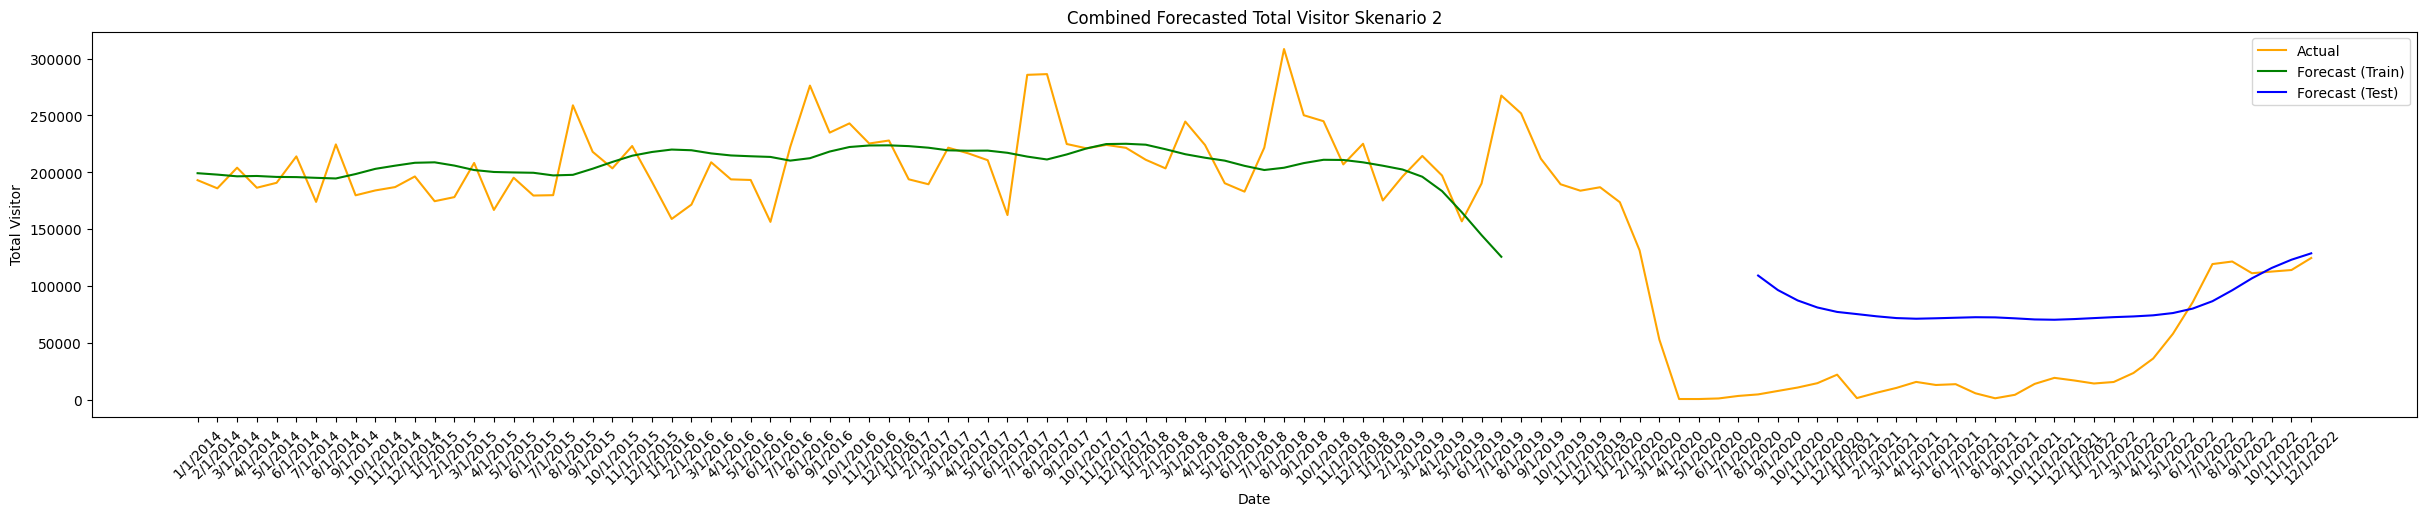

In [ ]:
plt.figure(figsize=(30, 5))

# Plot data aktual
plt.plot(jkt['datetime'], jkt['total_visitor'], label='Actual', color='orange')

# Plot hasil prediksi train
plt.plot(jkt['datetime'][:len(train_predictions_inverse2)], train_predictions_inverse2, label='Forecast (Train)', color='green')

# Plot hasil prediksi test
plt.plot(jkt['datetime'][-len(test_predictions_inverse2):], test_predictions_inverse2, label='Forecast (Test)', color='blue')

plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.title('Combined Forecasted Total Visitor Skenario 2')
plt.legend()
# Penyesuaian rotasi pada sumbu x
plt.xticks(rotation=45)  # Memutar teks pada sumbu x sebesar 45 derajat
plt.show()


###Forecast 12 Month Afterwards

In [ ]:
# Predict for 12 month afterwards
n_past = 1
n_month_for_prediction = 12
predict_period_month = pd.date_range(list(datetime)[-n_past], periods=n_month_for_prediction, freq='M').tolist()
print(predict_period_month)

[Timestamp('2022-12-31 00:00:00', freq='M'), Timestamp('2023-01-31 00:00:00', freq='M'), Timestamp('2023-02-28 00:00:00', freq='M'), Timestamp('2023-03-31 00:00:00', freq='M'), Timestamp('2023-04-30 00:00:00', freq='M'), Timestamp('2023-05-31 00:00:00', freq='M'), Timestamp('2023-06-30 00:00:00', freq='M'), Timestamp('2023-07-31 00:00:00', freq='M'), Timestamp('2023-08-31 00:00:00', freq='M'), Timestamp('2023-09-30 00:00:00', freq='M'), Timestamp('2023-10-31 00:00:00', freq='M'), Timestamp('2023-11-30 00:00:00', freq='M')]


In [ ]:
# Predict total_visitor using the trained model
predictions2 = model2.predict(test_x2[-n_month_for_prediction:])

# Calculate evaluation metrics
mae2 = mean_absolute_error(test_y2[-n_month_for_prediction:], predictions2)
mse2 = mean_squared_error(test_y2[-n_month_for_prediction:], predictions2)
mape2 = mean_absolute_percentage_error(test_y2[-n_month_for_prediction:], predictions2)

print("Mean Absolute Error (MAE):", mae2)
print("Mean Squared Error (MSE):", mse2)
print("Mean Absolute Percentage Error (MAPE):", mape2)

1/1 [==============================] - 1s 661ms/step
Mean Absolute Error (MAE): 0.08466143608135268
Mean Squared Error (MSE): 0.011609195198848135
Mean Absolute Percentage Error (MAPE): 1.0557529837157689


In [ ]:
prediction2_copy = np.repeat(predictions2, data_for_pred.shape[1], axis=-1)
y_pred2_future = scaler.inverse_transform(prediction2_copy)[:,0]

<ipython-input-46-a3e0cc0f5233>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['datetime'] = pd.to_datetime(actual['datetime'])


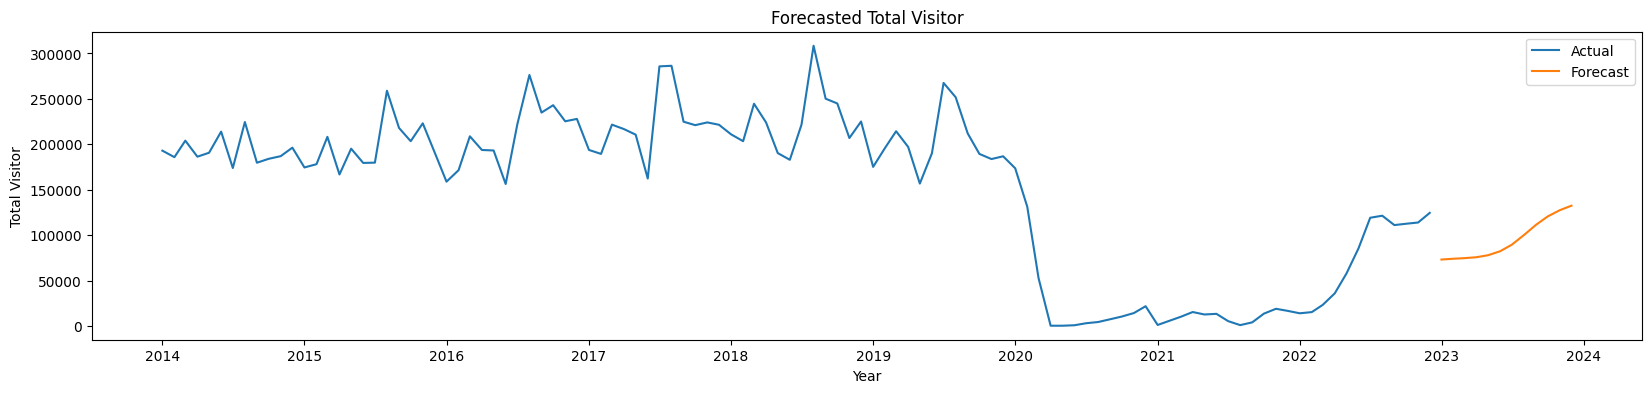

╒═════════════════════╤══════════════╕
│ Datetime            │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │      71641.6 │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │      72478.8 │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │      73109.4 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │      74087.3 │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │      76085.4 │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │      80019.4 │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │      86517.6 │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │      96126.4 │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │     106666   │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │     115774   │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │     123023   │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

In [ ]:
forecast_dates = []

for time_i in predict_period_month:
    forecast_dates.append(time_i.date())

df_forecast_2 = pd.DataFrame({'Date': forecast_dates, 'Total Visitor' : y_pred2_future})
df_forecast_2['Date'] = pd.to_datetime(df_forecast_2['Date'])

plt.figure(figsize=(20,4))
# Assuming 'actual' contains the actuals data with 'Datetime' and 'total_visitor' columns
actual = jkt[['datetime', 'total_visitor']]
actual['datetime'] = pd.to_datetime(actual['datetime'])
actual = actual.loc[actual['datetime'] >= '2014-01-01']

sns.lineplot(data=actual, x='datetime', y='total_visitor', label='Actual')
sns.lineplot(data=df_forecast_2, x='Date', y='Total Visitor', label='Forecast')

plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.title('Forecasted Total Visitor')
plt.legend()
plt.show()

# Generate the forecast dates from January 2023 to December 2023
forecast_dates_1 = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

# Create a list of forecast dates and prediction values
data_forecast2 = list(zip(forecast_dates_1, y_pred2_future))

# Create a list of headers for the table
headers = ['Datetime', 'Prediction']
table_pred = tabulate(data, headers=headers, tablefmt='fancy_grid')
# Print the table
print(table_pred)

##Skenario 3

60% training (65) dan 40% testing (43)

###Splitting Data

In [ ]:
# Define sequence length and features
n_past = 12  # Number of time steps in each sequence
num_features = len(data_for_pred.columns)
n_future = 1

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range (n_past, len(scaled_data_pred) - n_future +1):
    seq = scaled_data_pred[i - n_past:i, 0:scaled_data_pred.shape[1]]
    label = scaled_data_pred[i + n_future - 1:i + n_future, 0]  # 'total_visitor' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.6 * len(sequences))
train_x3, test_x3 = sequences[:train_size], sequences[train_size:]
train_y3, test_y3 = labels[:train_size], labels[train_size:]

print("Train X 3 shape:", train_x3.shape)
print("Train Y 3 shape:", train_y3.shape)
print("Test X 3 shape:", test_x3.shape)
print("Test Y 3 shape:", test_y3.shape)

Train X 3 shape: (57, 12, 2)
Train Y 3 shape: (57, 1)
Test X 3 shape: (39, 12, 2)
Test Y 3 shape: (39, 1)


###Model

In [ ]:
# Define the GRU model
model3 = Sequential()

# Add GRU layers with dropout
model3.add(GRU(units=256, input_shape=(train_x3.shape[1], train_x3.shape[2]), return_sequences=True))
model3.add(Dropout(0.2))

model3.add(GRU(units=128, return_sequences=True))
model.add(Dropout(0.2))

model3.add(GRU(units=64, return_sequences=False))

# Add a dense output layer
model3.add(Dense(units=1))

model3.summary()

# Compile the model
model3.compile(optimizer='adam', loss='mean_squared_error')


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 12, 256)           199680    
                                                                 
 dropout_6 (Dropout)         (None, 12, 256)           0         
                                                                 
 gru_10 (GRU)                (None, 12, 128)           148224    
                                                                 
 gru_11 (GRU)                (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 385217 (1.47 MB)
Trainable params: 385217 (1.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
history3 = model3.fit(
    train_x3, train_y3,
    epochs=100,
    batch_size=64,
    validation_split=0.2,  # Use part of the training data as validation
)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.5425 - val_loss: 0.2185
Epoch 2/100
1/1 [==============================] - 0s 102ms/step - loss: 0.2498 - val_loss: 0.0395
Epoch 3/100
1/1 [==============================] - 0s 107ms/step - loss: 0.0680 - val_loss: 0.0397
Epoch 4/100
1/1 [==============================] - 0s 107ms/step - loss: 0.0156 - val_loss: 0.1986
Epoch 5/100
1/1 [==============================] - 0s 100ms/step - loss: 0.0979 - val_loss: 0.1822
Epoch 6/100
1/1 [==============================] - 0s 94ms/step - loss: 0.0914 - val_loss: 0.0863
Epoch 7/100
1/1 [==============================] - 0s 95ms/step - loss: 0.0356 - val_loss: 0.0257
Epoch 8/100
1/1 [==============================] - 0s 104ms/step - loss: 0.0126 - val_loss: 0.0120
Epoch 9/100
1/1 [==============================] - 0s 101ms/step - loss: 0.0218 - val_loss: 0.0195
Epoch 10/100
1/1 [==============================] - 0s 96ms/step - loss: 0.0378 - val_loss: 0.0267
Epoch 11/100
1/

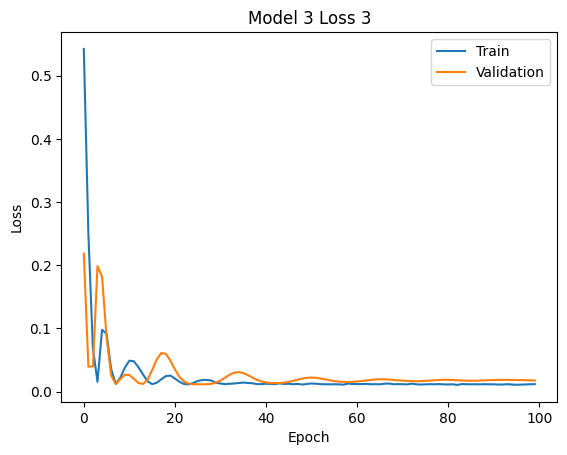

In [ ]:
# Plot training & validation loss values
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model 3 Loss 3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Retrieve loss values
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']

# Create a table with loss values
loss_table = []
for epoch in range(len(train_loss)):
    loss_table.append([epoch+1, train_loss[epoch], val_loss[epoch]])

headers = ["Epoch", "Train Loss", "Validation Loss"]

# Print the loss table using tabulate
print(tabulate(loss_table, headers=headers, tablefmt='fancy_grid'))

╒═════════╤══════════════╤═══════════════════╕
│   Epoch │   Train Loss │   Validation Loss │
╞═════════╪══════════════╪═══════════════════╡
│       1 │    0.542505  │         0.218536  │
├─────────┼──────────────┼───────────────────┤
│       2 │    0.249759  │         0.039537  │
├─────────┼──────────────┼───────────────────┤
│       3 │    0.0680264 │         0.0396916 │
├─────────┼──────────────┼───────────────────┤
│       4 │    0.015598  │         0.198645  │
├─────────┼──────────────┼───────────────────┤
│       5 │    0.0978675 │         0.182201  │
├─────────┼──────────────┼───────────────────┤
│       6 │    0.0914183 │         0.086301  │
├─────────┼──────────────┼───────────────────┤
│       7 │    0.0355908 │         0.0256957 │
├─────────┼──────────────┼───────────────────┤
│       8 │    0.0125773 │         0.0119739 │
├─────────┼──────────────┼───────────────────┤
│       9 │    0.021846  │         0.0194693 │
├─────────┼──────────────┼───────────────────┤
│      10 │  

###Forecast Data Train

2/2 [==============================] - 0s 13ms/step


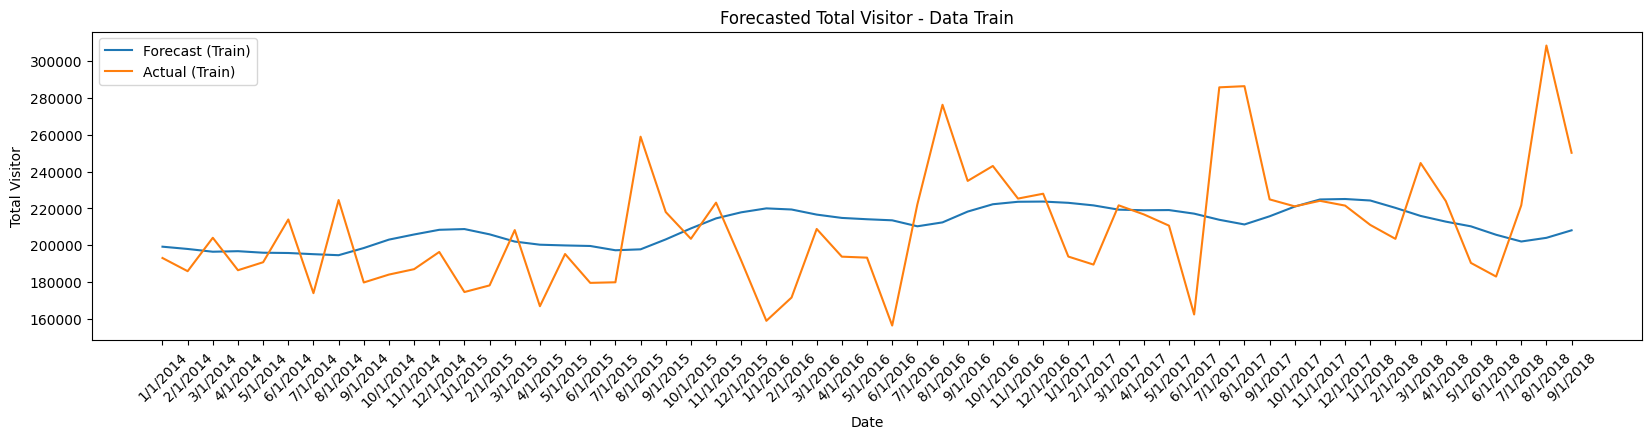

Data Forecast - Data Train
         Date  Forecast_Train  Actual_Train
0    1/1/2014   199161.531250        193017
1    2/1/2014   197923.921875        185851
2    3/1/2014   196423.312500        204004
3    4/1/2014   196717.343750        186373
4    5/1/2014   195884.593750        190716
5    6/1/2014   195729.578125        213950
6    7/1/2014   195091.078125        173914
7    8/1/2014   194534.875000        224492
8    9/1/2014   198432.078125        179723
9   10/1/2014   203000.734375        184012
10  11/1/2014   205792.640625        186945
11  12/1/2014   208335.359375        196298
12   1/1/2015   208736.625000        174525
13   2/1/2015   205871.203125        178124
14   3/1/2015   201942.875000        208180
15   4/1/2015   200238.500000        166819
16   5/1/2015   199839.531250        195175
17   6/1/2015   199541.734375        179499
18   7/1/2015   197217.453125        179825
19   8/1/2015   197724.375000        258916
20   9/1/2015   203117.062500        217994
21  1

In [ ]:
# Forecast Data Train
# Prediksi pada data train
train_predictions3 = model.predict(train_x3)

# Invers transformasi prediksi ke skala aslinya
train_predictions_inverse3 = scaler.inverse_transform(np.repeat(train_predictions3, data_for_pred.shape[1], axis=-1))[:, 0]

# Plot hasil prediksi bersama dengan data asli untuk data train
plt.figure(figsize=(20, 4))
plt.plot(jkt['datetime'][:len(train_predictions_inverse3)], train_predictions_inverse3, label='Forecast (Train)')
plt.plot(jkt['datetime'][:len(train_predictions_inverse3)], jkt['total_visitor'][:len(train_predictions_inverse3)], label='Actual (Train)')
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.title('Forecasted Total Visitor - Data Train')
plt.legend()

# Penyesuaian rotasi pada sumbu x
plt.xticks(rotation=45)  # Memutar teks pada sumbu x sebesar 45 derajat

plt.show()
# Membuat DataFrame untuk data forecast dari data train
df_forecast_train3 = pd.DataFrame({
    'Date': jkt['datetime'][:len(train_predictions_inverse3)],
    'Forecast_Train': train_predictions_inverse3,
    'Actual_Train': jkt['total_visitor'][:len(train_predictions_inverse3)]
})

# Menampilkan tabel untuk data forecast dari data train
print("Data Forecast - Data Train")
print(df_forecast_train3)

###Forecast Data Test

2/2 [==============================] - 0s 7ms/step

Data Forecast - Data Test
          Date  Forecast_Test  Actual_Test
69   10/1/2019  210976.171875       189426
70   11/1/2019  210807.015625       183768
71   12/1/2019  208729.343750       186810
72    1/1/2020  205762.906250       173614
73    2/1/2020  202401.140625       131237
74    3/1/2020  196044.000000        52721
75    4/1/2020  183406.640625          424
76    5/1/2020  164794.968750          414
77    6/1/2020  144658.609375          924
78    7/1/2020  125608.562500         3146
79    8/1/2020  109092.109375         4487
80    9/1/2020   96322.476562         7528
81   10/1/2020   87193.835938        10529
82   11/1/2020   80986.843750        14365
83   12/1/2020   77072.109375        21858
84    1/1/2021   75168.031250         1248
85    2/1/2021   73216.250000         5966
86    3/1/2021   71662.757812        10198
87    4/1/2021   71089.242188        15482
88    5/1/2021   71480.750000        12782
89    6/1/2021   71

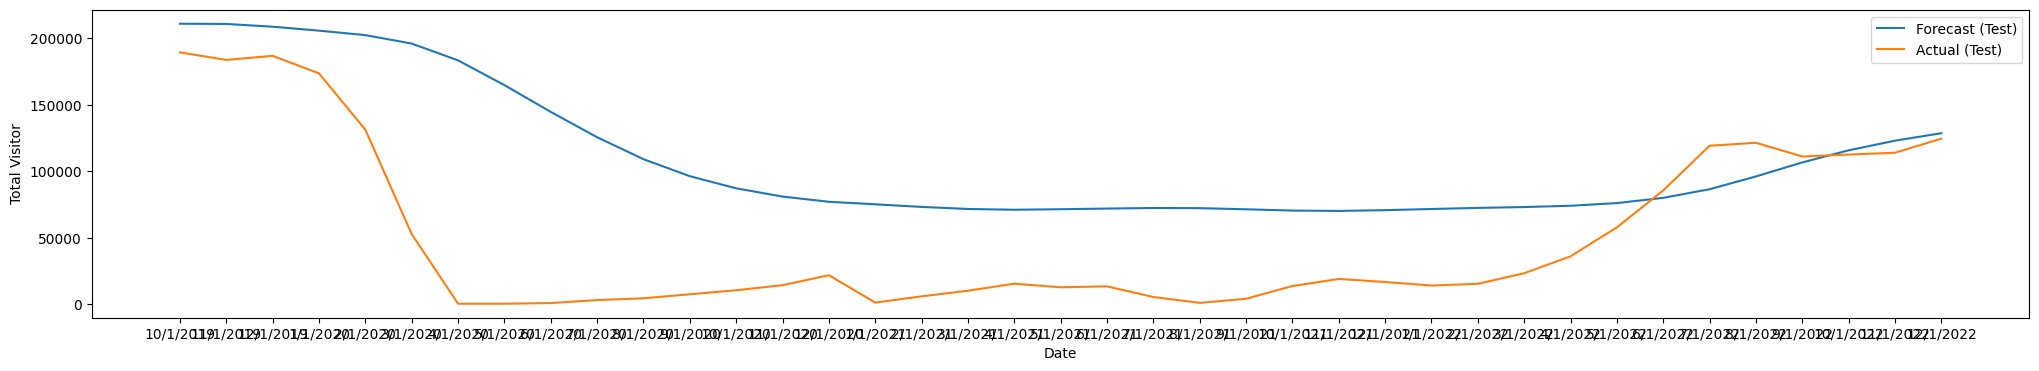

In [ ]:
# Forecast Data Test
# Prediksi pada data test
test_predictions3 = model.predict(test_x3)

# Invers transformasi prediksi ke skala aslinya
test_predictions_inverse3 = scaler.inverse_transform(np.repeat(test_predictions3, data_for_pred.shape[1], axis=-1))[:, 0]

# Plot hasil prediksi bersama dengan data asli untuk data test
plt.figure(figsize=(25, 4))
plt.plot(jkt['datetime'][-len(test_predictions_inverse3):], test_predictions_inverse3, label='Forecast (Test)')
plt.plot(jkt['datetime'][-len(test_predictions_inverse3):], jkt['total_visitor'][-len(test_predictions_inverse3):], label='Actual (Test)')
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.legend()
plt

# Membuat DataFrame untuk data forecast dari data test
df_forecast_test3 = pd.DataFrame({
    'Date': jkt['datetime'][-len(test_predictions_inverse3):],
    'Forecast_Test': test_predictions_inverse3,
    'Actual_Test': jkt['total_visitor'][-len(test_predictions_inverse3):]
})

# Menampilkan tabel untuk data forecast dari data test
print("\nData Forecast - Data Test")
print(df_forecast_test3)

###Visual Forecast Train dan Test

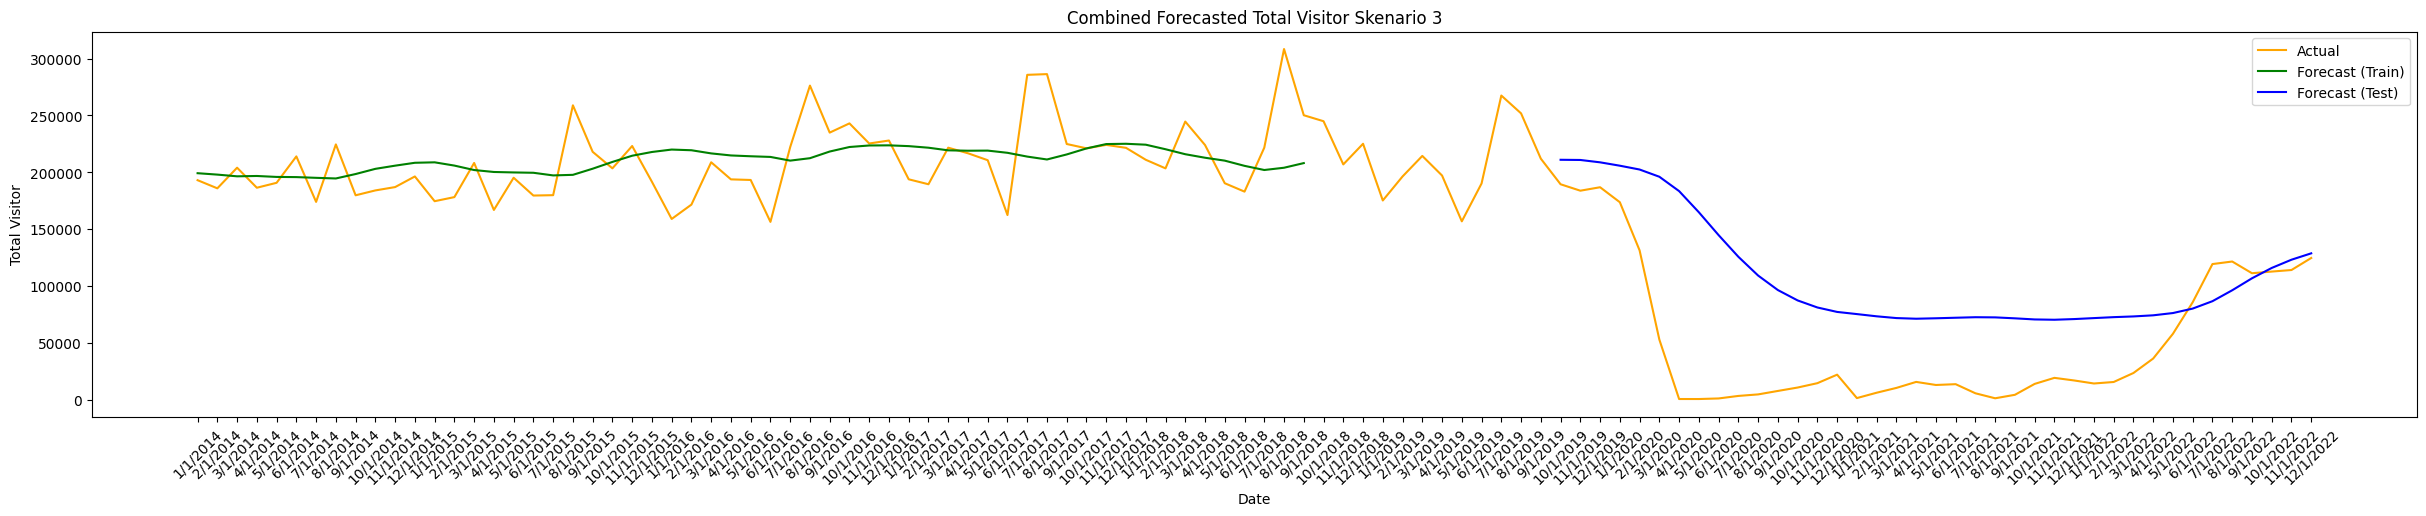

In [ ]:
plt.figure(figsize=(30, 5))

# Plot data aktual
plt.plot(jkt['datetime'], jkt['total_visitor'], label='Actual', color='orange')

# Plot hasil prediksi train
plt.plot(jkt['datetime'][:len(train_predictions_inverse3)], train_predictions_inverse3, label='Forecast (Train)', color='green')

# Plot hasil prediksi test
plt.plot(jkt['datetime'][-len(test_predictions_inverse3):], test_predictions_inverse3, label='Forecast (Test)', color='blue')

plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.title('Combined Forecasted Total Visitor Skenario 3')
plt.legend()
# Penyesuaian rotasi pada sumbu x
plt.xticks(rotation=45)  # Memutar teks pada sumbu x sebesar 45 derajat
plt.show()


###Predict for 12 Month Afterwards

In [ ]:
# Predict for 12 month afterwards
n_past = 1
n_month_for_prediction = 12
predict_period_month = pd.date_range(list(datetime)[-n_past], periods=n_month_for_prediction, freq='M').tolist()
print(predict_period_month)

[Timestamp('2022-12-31 00:00:00', freq='M'), Timestamp('2023-01-31 00:00:00', freq='M'), Timestamp('2023-02-28 00:00:00', freq='M'), Timestamp('2023-03-31 00:00:00', freq='M'), Timestamp('2023-04-30 00:00:00', freq='M'), Timestamp('2023-05-31 00:00:00', freq='M'), Timestamp('2023-06-30 00:00:00', freq='M'), Timestamp('2023-07-31 00:00:00', freq='M'), Timestamp('2023-08-31 00:00:00', freq='M'), Timestamp('2023-09-30 00:00:00', freq='M'), Timestamp('2023-10-31 00:00:00', freq='M'), Timestamp('2023-11-30 00:00:00', freq='M')]


In [ ]:
# Predict total_visitor using the trained model
predictions3 = model3.predict(test_x3[-n_month_for_prediction:])

# Calculate evaluation metrics
mae3 = mean_absolute_error(test_y3[-n_month_for_prediction:], predictions3)
mse3 = mean_squared_error(test_y3[-n_month_for_prediction:], predictions3)
mape3 = mean_absolute_percentage_error(test_y3[-n_month_for_prediction:], predictions3)

print("Mean Absolute Error (MAE):", mae3)
print("Mean Squared Error (MSE):", mse3)
print("Mean Absolute Percentage Error (MAPE):", mape3)

1/1 [==============================] - 1s 660ms/step
Mean Absolute Error (MAE): 0.26752106637431583
Mean Squared Error (MSE): 0.08072413653371827
Mean Absolute Percentage Error (MAPE): 2.598113335459472


In [ ]:
prediction3_copy = np.repeat(predictions3, data_for_pred.shape[1], axis=-1)
y_pred3_future = scaler.inverse_transform(prediction3_copy)[:,0]

<ipython-input-58-a5f2796d253a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['datetime'] = pd.to_datetime(actual['datetime'])


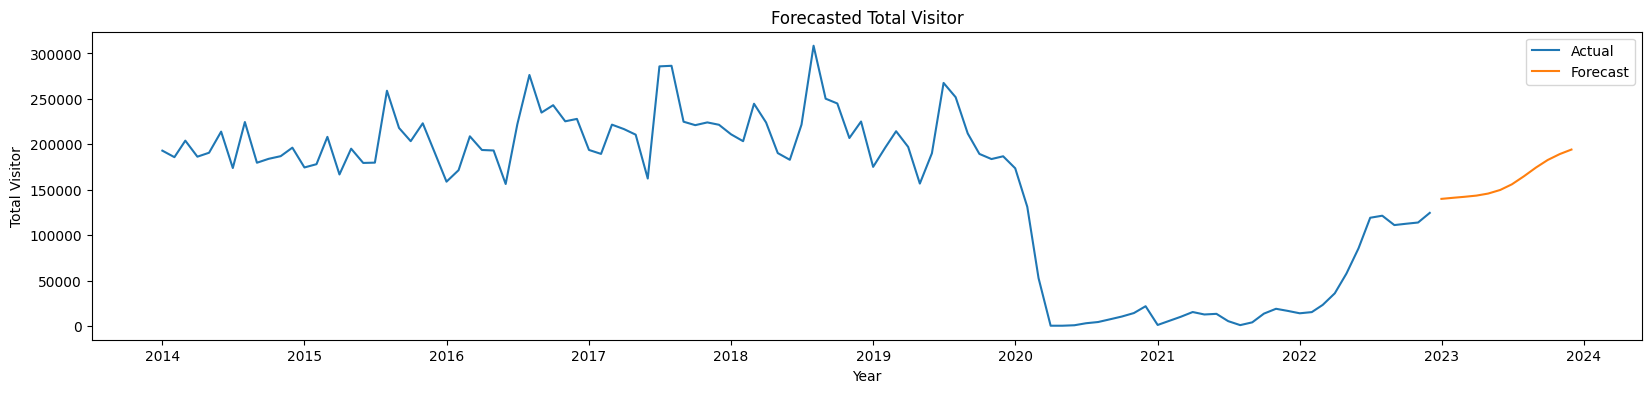

╒═════════════════════╤══════════════╕
│ Datetime            │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │       139962 │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │       141194 │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │       142233 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │       143564 │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │       145808 │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │       149776 │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │       155977 │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │       164853 │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │       174467 │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │       182740 │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │       189253 │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

In [ ]:
forecast_dates = []

for time_i in predict_period_month:
    forecast_dates.append(time_i.date())

df_forecast_3 = pd.DataFrame({'Date': forecast_dates, 'Total Visitor' : y_pred3_future})
df_forecast_3['Date'] = pd.to_datetime(df_forecast_3['Date'])

plt.figure(figsize=(20,4))
# Assuming 'actual' contains the actuals data with 'Datetime' and 'total_visitor' columns
actual = jkt[['datetime', 'total_visitor']]
actual['datetime'] = pd.to_datetime(actual['datetime'])
actual = actual.loc[actual['datetime'] >= '2014-01-01']

sns.lineplot(data=actual, x='datetime', y='total_visitor', label='Actual')
sns.lineplot(data=df_forecast_3, x='Date', y='Total Visitor', label='Forecast')

plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.title('Forecasted Total Visitor')
plt.legend()
plt.show()

# Generate the forecast dates from January 2023 to December 2023
forecast_dates_1 = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

# Create a list of forecast dates and prediction values
data = list(zip(forecast_dates_1, y_pred3_future))

# Create a list of headers for the table
headers = ['Datetime', 'Prediction']
table_pred = tabulate(data, headers=headers, tablefmt='fancy_grid')
# Print the table
print(table_pred)

##Kesimpulan

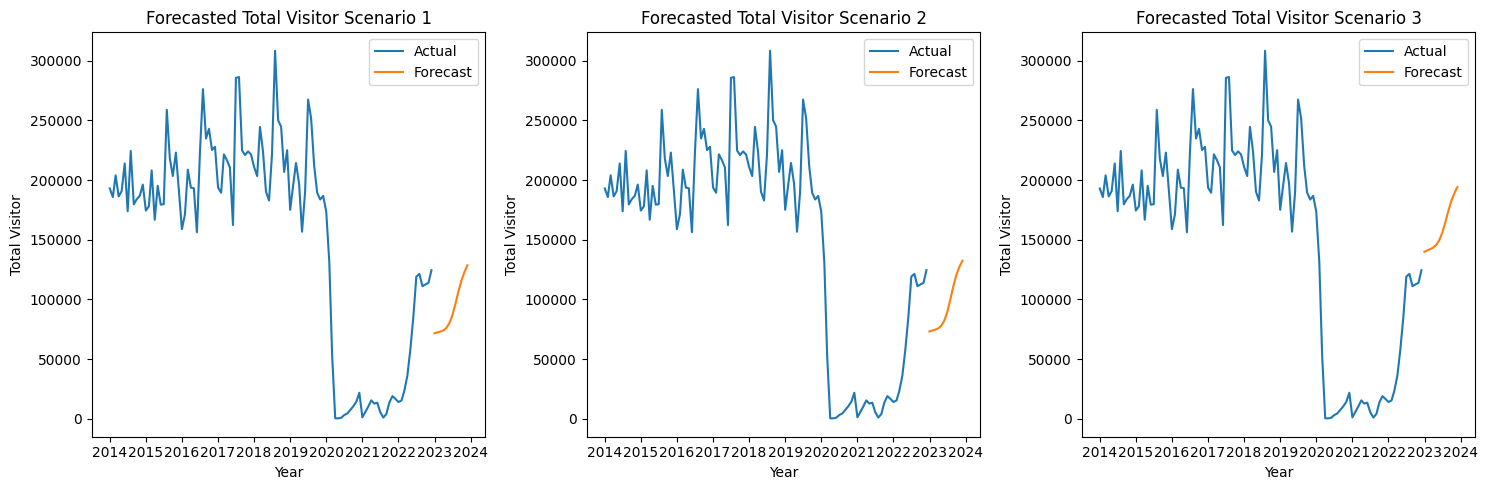

╒════════════╤═════════╤═══════════╤═══════════╤═════════╕
│ Skenario   │ Model   │       MAE │       MSE │    MAPE │
╞════════════╪═════════╪═══════════╪═══════════╪═════════╡
│ Skenario 1 │ GRU     │ 0.0825274 │ 0.0111504 │ 1.02539 │
├────────────┼─────────┼───────────┼───────────┼─────────┤
│ Skenario 2 │ GRU     │ 0.0846614 │ 0.0116092 │ 1.05575 │
├────────────┼─────────┼───────────┼───────────┼─────────┤
│ Skenario 3 │ GRU     │ 0.267521  │ 0.0807241 │ 2.59811 │
╘════════════╧═════════╧═══════════╧═══════════╧═════════╛


In [ ]:
plt.figure(figsize=(15, 5))

# Skenario 1
plt.subplot(1, 3, 1)
sns.lineplot(data=actual, x='datetime', y='total_visitor', label='Actual')
sns.lineplot(data=df_forecast_1, x='Date', y='Total Visitor', label='Forecast')
plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.title('Forecasted Total Visitor Scenario 1')
plt.legend()

# Skenario 2
plt.subplot(1, 3, 2)
sns.lineplot(data=actual, x='datetime', y='total_visitor', label='Actual')
sns.lineplot(data=df_forecast_2, x='Date', y='Total Visitor', label='Forecast')
plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.title('Forecasted Total Visitor Scenario 2')
plt.legend()

# Skenario 3
plt.subplot(1, 3, 3)
sns.lineplot(data=actual, x='datetime', y='total_visitor', label='Actual')
sns.lineplot(data=df_forecast_3, x='Date', y='Total Visitor', label='Forecast')
plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.title('Forecasted Total Visitor Scenario 3')
plt.legend()

plt.tight_layout()
plt.show()

# Define the data for each scenario
skenario_data = [
    {
        'Skenario': 'Skenario 1',
        'Model': 'GRU',
        'MAE' : mae1,
        'MSE': mse1,
        'MAPE': mape1
    },
    {
        'Skenario': 'Skenario 2',
        'Model': 'GRU',
        'MAE' : mae2,
        'MSE': mse2,
        'MAPE': mape2
    },
    {
        'Skenario': 'Skenario 3',
        'Model': 'GRU',
        'MAE' : mae3,
        'MSE': mse3,
        'MAPE': mape3
    }
]

# Create a DataFrame from the scenario data
df = pd.DataFrame(skenario_data)

# Convert DataFrame to a list of rows
rows = df.values.tolist()

# Create a list of headers
headers = df.columns.tolist()

# Generate the table
tabel_rekap = tabulate(rows, headers=headers, tablefmt='fancy_grid')

# Print the table
print(tabel_rekap)

